In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from random import uniform

from sklearn import metrics
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [6]:
data = pd.read_csv("train.csv")
data.shape

(891, 12)

In [14]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


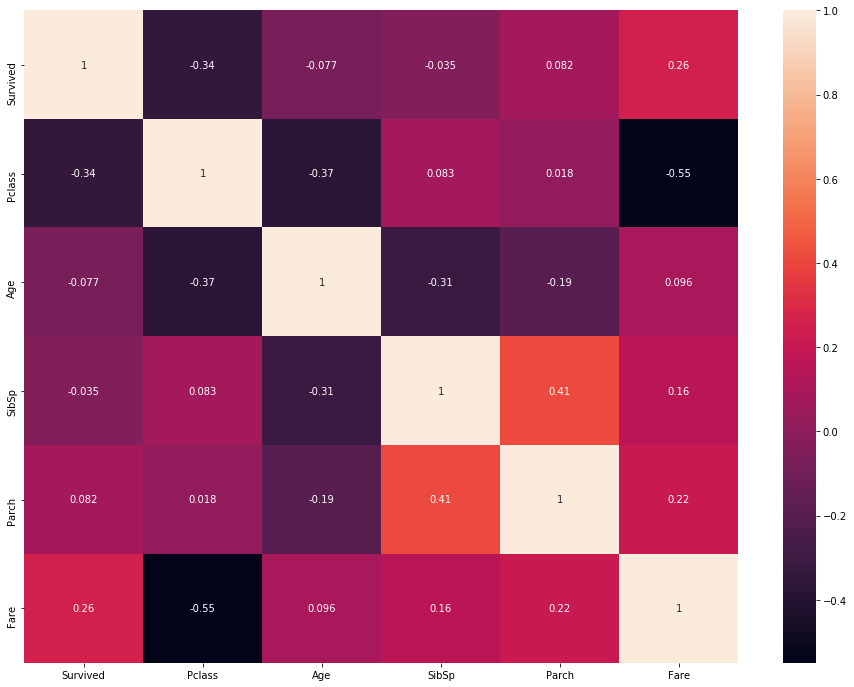

In [8]:
correlation = data.drop(columns="PassengerId").corr()
fig = plt.figure(figsize=(16,12))
sn.heatmap(correlation, annot=True)
plt.show()

### normalization

In [10]:
def mi_ma(arr):
    return arr.min(), arr.max()
def normalize(arr):
    mi,ma = mi_ma(arr)
    norm = lambda x : (x -mi)/(ma -mi)
    return np.array([norm(x) for x in arr])

In [11]:
encoder = LabelEncoder()

### 60% of people who embarked at S died

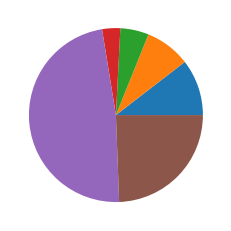

In [6]:
plt.pie(data.groupby("Embarked") \
        .Survived.value_counts())
plt.show()

In [7]:
data.groupby("Embarked") \
    .Survived.value_counts()

Embarked  Survived
C         1            93
          0            75
Q         0            47
          1            30
S         0           427
          1           217
Name: Survived, dtype: int64

### Age histogram

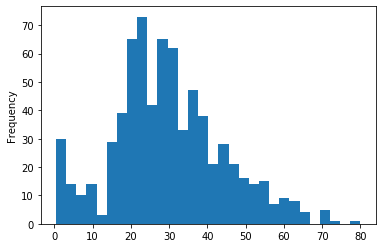

In [8]:
data.Age.plot(kind="hist", bins=30)

In [9]:
data.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [12]:
# Drop irrelevant columns
train = data.drop(columns=["PassengerId", "Name", "Ticket", "SibSp", "Parch"])

train.Sex = encoder.fit_transform(train.Sex)

# Use place of most embarked as fillna-value
embarked_most = train.Embarked.mode()[0]
train.Embarked.fillna(embarked_most, inplace=True)
train.Embarked = encoder.fit_transform(train.Embarked)

# Set missing age data between range
# min age + 10 && max age - 10
mi, ma = mi_ma(train.Age)
mi += 10; ma -= 10
mi, ma = 16, 65
train.Age = data.Age
train.Age = train.Age.apply(lambda x: uniform(mi, ma) if pd.isnull(x) else x)
train.Age = normalize(train.Age)
train.Age = train.Age.apply(lambda x: x*5)
# Weighted Age & Fare 5-fold (important factors)
train.Fare = normalize(train.Fare)
train.Fare = train.Fare.apply(lambda x: x*5)

train.Cabin = train.Cabin.apply(lambda x: re.findall(r"[A-Z]", x)[0]
                                if type(x)==str else x)
cabin_train = train[["Fare","Cabin"]][pd.isnull(train.Cabin)==False]
#model = SVC().fit(np.array(cabin_train.Fare).reshape(-1,1), cabin_train.Cabin)
#train.Cabin = train.apply(lambda x: model.predict(np.array(x["Fare"]).reshape(-1,1))[0]
#                                if pd.isnull(x["Cabin"]) else x["Cabin"], axis=1)

train.Cabin = train.Cabin.apply(lambda x: "2" if pd.isnull(x) else x)
train.Cabin = encoder.fit_transform(train.Cabin)
train.Cabin.value_counts()

# Cabin Model

#train.Cabin = train.Cabin.apply(lambda x: re.findall(f"[A-Z]", x)[0]
#                                if type(x)==str else x)
#cabin_fare = train[["Fare","Cabin","Survived"]][pd.isnull(train.Cabin)==False]
#model = SVC(kernel="linear", C=1, gamma="auto").fit(
#        np.array(cabin_fare[["Fare", "Survived"]]).reshape(-1,2), cabin_fare.Cabin)
#train.Cabin = train.apply(lambda x: model.predict(np.array(x[["Fare","Survived"]]).reshape(-1,2))[0] 
#                          if pd.isnull(x["Cabin"]) else x["Cabin"], axis=1)
#train.Cabin = encoder.fit_transform(train.Cabin)

0    687
3     59
2     47
4     33
5     32
1     15
6     13
7      4
8      1
Name: Cabin, dtype: int64

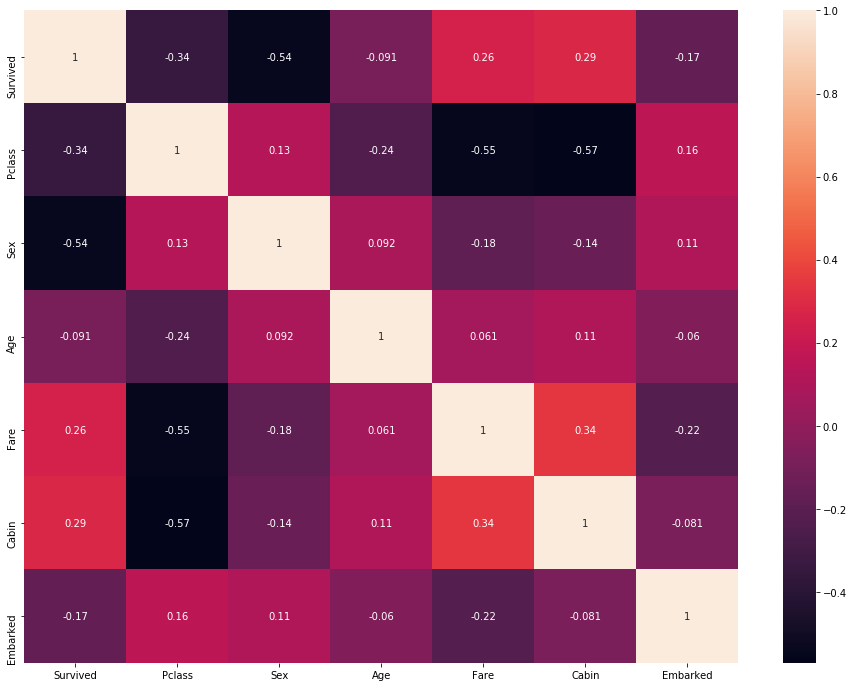

In [24]:
correlation = train.corr()
fig = plt.figure(figsize=(16,12))
sn.heatmap(correlation, annot=True)
plt.show()

In [35]:
# Fit model 500 times for percentile stats
survived = train.Survived
train = train.drop(columns=["Survived"])
result = []
for i in range(500):
    X_train, X_test, y_train, y_test = train_test_split(train, survived, test_size=0.3)
    classifier = SVC(kernel="linear", gamma="auto").fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    result.append(metrics.accuracy_score(y_test, y_pred))
pd.DataFrame(result).describe().T

,count,mean,std,min,25%,50%,75%,max
0,500.0,0.788806,0.021193,0.731343,0.772388,0.787313,0.80597,0.847015


In [12]:
test = pd.read_csv("test.csv")
test = test.drop(columns=["Name", "Ticket", "SibSp", "Parch"])
test.set_index("PassengerId", inplace=True)
test.head()

,Pclass,Sex,Age,Fare,Cabin,Embarked
PassengerId,,,,,,
892,3,male,34.5,7.8292,NaN,Q
893,3,female,47.0,7.0000,NaN,S
894,2,male,62.0,9.6875,NaN,Q
895,3,male,27.0,8.6625,NaN,S
896,3,female,22.0,12.2875,NaN,S


In [13]:
test.isnull().sum().to_frame().T

,Pclass,Sex,Age,Fare,Cabin,Embarked
0,0,0,86,1,327,0


In [14]:
test.Age = test.Age.apply(lambda x: uniform(mi, ma) if pd.isnull(x) else x)
test.Age = normalize(test.Age)
test.Age = test.Age.apply(lambda x: x*5)
test.Sex = encoder.fit_transform(test.Sex)
test.Fare.fillna(test.Fare.median(), inplace=True)
test.Fare = normalize(test.Fare)
test.Fare = test.Fare.apply(lambda x: x*5)
test.Cabin = test.apply(lambda x: model.predict(np.array(x["Fare"]).reshape(-1,1))[0] 
                          if pd.isnull(x["Cabin"]) else x["Cabin"], axis=1)
print(test.isnull().sum().to_frame().T)
test.head()

   Pclass  Sex  Age  Fare  Cabin  Embarked
0       0    0    0     0      0         0


,Pclass,Sex,Age,Fare,Cabin,Embarked
PassengerId,,,,,,
892,3,1,2.263616,0.076408,E,Q
893,3,0,3.087828,0.068315,E,S
894,2,1,4.076883,0.094544,E,Q
895,3,1,1.769089,0.084540,E,S
896,3,0,1.439404,0.119918,E,S
